<a href="https://colab.research.google.com/github/lahirumanulanka/ann-visual-emotion/blob/old-Dataset/notebooks/emo_CNN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!git clone -b old-Dataset https://github.com/lahirumanulanka/ann-visual-emotion

fatal: destination path 'ann-visual-emotion' already exists and is not an empty directory.


## 1) Setup & Imports

In [10]:
import os, math, json, random, time
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [11]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


## 2) Config & Label Map

In [12]:
BASE_DIR = "/content/ann-visual-emotion/data/processed/EmoSet_splits"
BASE_DATA_URL = "/content/ann-visual-emotion"

# File paths
CSV_TRAIN = f"{BASE_DIR}/train.csv"
CSV_VAL   = f"{BASE_DIR}/val.csv"
CSV_TEST  = f"{BASE_DIR}/test.csv"

# Column names in the CSVs
COL_IMAGE = 'image'
COL_LABEL = 'label'

# Training hyperparameters
IMG_SIZE     = 224
BATCH_SIZE   = 32
EPOCHS       = 20
BASE_LR      = 3e-4
WEIGHT_DECAY = 1e-4
LABEL_SMOOTH = 0.05
USE_SAMPLER  = True            # balanced mini-batches
MIXUP_ALPHA  = 0.0             # set to 0.2~0.4 to enable MixUp

# Checkpoint path
CKPT_PATH = 'best_resnet18_balanced.pt'

## 3) Load CSVs & Quick EDA

In [13]:
train_df = pd.read_csv(CSV_TRAIN)
val_df   = pd.read_csv(CSV_VAL)
test_df  = pd.read_csv(CSV_TEST)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print(train_df.head())

Train: 13864 Val: 1734 Test: 1734
                                          image_path        label
0  data/raw/EmoSet/contentment/contentment_09260.jpg  contentment
1              data/raw/EmoSet/anger/anger_06224.jpg        anger
2  data/raw/EmoSet/contentment/contentment_03550.jpg  contentment
3          data/raw/EmoSet/sadness/sadness_08827.jpg      sadness
4  data/raw/EmoSet/contentment/contentment_09558.jpg  contentment


In [14]:

def _auto_column(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of {candidates} found. Columns: {list(df.columns)}")


def load_csvs(csv_train, csv_val, csv_test=None, col_image='image_path', col_label='label'):
    tr = pd.read_csv(csv_train)
    va = pd.read_csv(csv_val)
    te = pd.read_csv(csv_test) if csv_test and os.path.exists(csv_test) else None

    if col_image not in tr.columns:
        col_image = _auto_column(tr, ['image_path','image','filepath','path','img_path','img'])
    if col_label not in tr.columns:
        col_label = _auto_column(tr, ['label','emotion','target','y'])

    for df in (tr, va) + ((te,) if te is not None else ()):
        df[col_image] = df[col_image].astype(str)
        df[col_label] = df[col_label].astype(str)

    labels = sorted(tr[col_label].unique().tolist())
    label_to_idx = {l:i for i,l in enumerate(labels)}
    idx_to_label = {i:l for l,i in label_to_idx.items()}

    tr['y'] = tr[col_label].map(label_to_idx)
    va['y'] = va[col_label].map(label_to_idx)
    if te is not None:
        before = len(te)
        te = te[te[col_label].isin(labels)].copy()
        if len(te) < before:
            print(f"[WARN] Dropped {before-len(te)} test rows with unseen labels.")
        te['y'] = te[col_label].map(label_to_idx)

    return tr, va, te, label_to_idx, idx_to_label, col_image, col_label


def resolve_path(p: str) -> str:
    """Return an absolute path. If not existing, try join with BASE_DATA_URL."""
    # Already absolute and exists
    if os.path.isabs(p) and os.path.exists(p):
        return p
    # Try relative to BASE_DATA_URL
    cand = os.path.join(BASE_DATA_URL, p.lstrip('/'))
    if os.path.exists(cand):
        return cand
    # As last resort, return original (may be handled by PIL if path becomes valid in Colab mount)
    return p


class ImageCSVDataset(Dataset):
    def __init__(self, df, img_col, y_col='y', transform=None):
        self.df = df.reset_index(drop=True)
        self.img_col = img_col
        self.y_col = y_col
        self.tfm = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = resolve_path(row[self.img_col])
        y = int(row[self.y_col])
        with Image.open(path) as im:
            im = im.convert('RGB')
        if self.tfm:
            im = self.tfm(im)
        return im, y


def compute_class_weights(y_int, power=0.5):
    counts = np.bincount(y_int)
    counts[counts==0] = 1
    w = (1.0 / counts) ** power
    w = w / w.sum() * len(counts)
    return torch.tensor(w, dtype=torch.float32)


def make_sampler(y_int):
    class_count = np.bincount(y_int)
    class_count[class_count==0] = 1
    class_weight = 1.0 / class_count
    sample_weight = np.array([class_weight[y] for y in y_int])
    return WeightedRandomSampler(weights=torch.from_numpy(sample_weight).double(),
                                 num_samples=len(sample_weight),
                                 replacement=True)


In [15]:
# Load CSVs
train_df, val_df, test_df, label_to_idx, idx_to_label, COL_IMAGE, COL_LABEL = load_csvs(
    CSV_TRAIN, CSV_VAL, CSV_TEST, COL_IMAGE, COL_LABEL
)
NUM_CLASSES = len(label_to_idx)
print('Classes:', label_to_idx)

# Transforms (ImageNet mean/std)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])
val_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

train_ds = ImageCSVDataset(train_df, img_col=COL_IMAGE, transform=train_tfms)
val_ds   = ImageCSVDataset(val_df,   img_col=COL_IMAGE, transform=val_tfms)
test_ds  = ImageCSVDataset(test_df,  img_col=COL_IMAGE, transform=val_tfms) if test_df is not None else None

# Sampler / Loaders
sampler = make_sampler(train_df['y'].values) if USE_SAMPLER else None
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=(sampler is None),
                          sampler=sampler, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True) if test_ds is not None else None

# Class weights (for CE)
class_weights = compute_class_weights(train_df['y'].values, power=0.5).to(device)
print('Class weights:', class_weights.cpu().numpy().round(3))

Classes: {'amusement': 0, 'anger': 1, 'awe': 2, 'contentment': 3, 'disgust': 4, 'excitement': 5, 'fear': 6, 'sadness': 7}
Class weights: [0.341 0.563 0.85  0.376 4.109 0.269 0.99  0.503]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [16]:
def build_model(num_classes):
    net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    # freeze all
    for p in net.parameters():
        p.requires_grad = False
    # unfreeze last block
    for p in net.layer4.parameters():
        p.requires_grad = True
    in_features = net.fc.in_features
    net.fc = nn.Linear(in_features, num_classes)
    return net

model = build_model(NUM_CLASSES).to(device)

# Optimizer / Scheduler
opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=BASE_LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]
/tmp/ipython-input-568396827.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [17]:
def mixup(images, labels, alpha=0.2):
    if alpha <= 0.0:
        return images, labels, labels, 1.0, False
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(images.size(0), device=images.device)
    mixed_x = lam * images + (1 - lam) * images[index, :]
    y_a, y_b = labels, labels[index]
    return mixed_x, y_a, y_b, lam, True

In [18]:
def epoch_pass(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    all_preds, all_tgts = [], []
    total_loss, total_n = 0.0, 0

    for ims, ys in loader:
        ims, ys = ims.to(device), ys.to(device)
        if train:
            opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            ims2, y_a, y_b, lam, used_mix = mixup(ims, ys, alpha=MIXUP_ALPHA if train else 0.0)
            logits = model(ims2)
            if used_mix:
                loss = lam*F.cross_entropy(logits, y_a, weight=class_weights, label_smoothing=LABEL_SMOOTH) + \
                       (1-lam)*F.cross_entropy(logits, y_b, weight=class_weights, label_smoothing=LABEL_SMOOTH)
            else:
                loss = F.cross_entropy(logits, ys, weight=class_weights, label_smoothing=LABEL_SMOOTH)
        if train:
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

        total_loss += loss.item() * ims.size(0)
        total_n    += ims.size(0)
        all_preds.append(logits.detach().cpu())
        all_tgts.append(ys.detach().cpu())

    if train:
        scheduler.step()

    y_true = torch.cat(all_tgts).numpy()
    y_pred = torch.cat(all_preds).argmax(1).numpy()

    # macro-F1 (simple sklearn computation)
    from sklearn.metrics import f1_score, accuracy_score
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    return total_loss/total_n, f1, acc, y_true, y_pred

In [19]:

best_f1 = 0.0
history = []

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_f1, tr_acc, _, _ = epoch_pass(train_loader, train=True)
    va_loss, va_f1, va_acc, y_true, y_pred = epoch_pass(val_loader, train=False)
    dt = time.time()-t0
    print(f"Epoch {epoch:02d} | train_loss {tr_loss:.4f} F1 {tr_f1:.3f} acc {tr_acc:.3f} || val_loss {va_loss:.4f} F1 {va_f1:.3f} acc {va_acc:.3f}  [{dt:.1f}s]")
    history.append((epoch, tr_loss, tr_f1, tr_acc, va_loss, va_f1, va_acc))

    if va_f1 > best_f1:
        best_f1 = va_f1
        torch.save({'model': model.state_dict(),
                    'label_to_idx': label_to_idx,
                    'idx_to_label': idx_to_label}, CKPT_PATH)
        print('  -> saved best checkpoint')

# Optionally unfreeze more and continue training if plateau (run again with different setup)


/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 01 | train_loss 0.7365 F1 0.554 acc 0.578 || val_loss 1.8256 F1 0.369 acc 0.437  [194.8s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 02 | train_loss 0.5868 F1 0.680 acc 0.695 || val_loss 1.7254 F1 0.408 acc 0.474  [186.9s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 03 | train_loss 0.5037 F1 0.730 acc 0.744 || val_loss 1.6756 F1 0.433 acc 0.503  [186.7s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 04 | train_loss 0.4655 F1 0.768 acc 0.780 || val_loss 1.6883 F1 0.431 acc 0.495  [186.4s]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 05 | train_loss 0.4328 F1 0.804 acc 0.811 || val_loss 1.6769 F1 0.446 acc 0.505  [190.0s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 06 | train_loss 0.4154 F1 0.828 acc 0.833 || val_loss 1.6262 F1 0.465 acc 0.542  [187.0s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 07 | train_loss 0.3780 F1 0.852 acc 0.856 || val_loss 1.6323 F1 0.457 acc 0.543  [190.7s]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 08 | train_loss 0.3602 F1 0.878 acc 0.882 || val_loss 1.5886 F1 0.467 acc 0.548  [193.2s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 09 | train_loss 0.3541 F1 0.886 acc 0.889 || val_loss 1.6128 F1 0.476 acc 0.555  [195.9s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 10 | train_loss 0.3519 F1 0.890 acc 0.893 || val_loss 1.5914 F1 0.473 acc 0.554  [190.3s]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 11 | train_loss 0.3465 F1 0.893 acc 0.897 || val_loss 1.5952 F1 0.490 acc 0.570  [186.2s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 12 | train_loss 0.3456 F1 0.893 acc 0.895 || val_loss 1.5949 F1 0.491 acc 0.573  [188.8s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 13 | train_loss 0.3443 F1 0.895 acc 0.899 || val_loss 1.6222 F1 0.498 acc 0.574  [188.4s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 14 | train_loss 0.3378 F1 0.895 acc 0.899 || val_loss 1.6240 F1 0.479 acc 0.570  [189.7s]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 15 | train_loss 0.3393 F1 0.896 acc 0.899 || val_loss 1.6485 F1 0.485 acc 0.572  [189.5s]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 16 | train_loss 0.3471 F1 0.886 acc 0.889 || val_loss 1.6875 F1 0.468 acc 0.539  [193.0s]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 17 | train_loss 0.3805 F1 0.873 acc 0.876 || val_loss 1.6730 F1 0.484 acc 0.567  [189.0s]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 18 | train_loss 0.3687 F1 0.871 acc 0.875 || val_loss 1.7542 F1 0.444 acc 0.546  [188.7s]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 19 | train_loss 0.3729 F1 0.873 acc 0.875 || val_loss 1.7004 F1 0.447 acc 0.533  [191.3s]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 20 | train_loss 0.3696 F1 0.872 acc 0.875 || val_loss 1.8438 F1 0.442 acc 0.505  [191.5s]


In [20]:
# Cell 0: Imports & helpers
import os, math, itertools, json, numpy as np, pandas as pd, torch
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score, top_k_accuracy_score,
                             brier_score_loss)
from sklearn.preprocessing import label_binarize

plt.rcParams["figure.dpi"] = 120

def to_numpy(x):
    return x.detach().cpu().numpy() if torch.is_tensor(x) else np.asarray(x)

def softmax_np(logits):
    e = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return e / np.sum(e, axis=1, keepdims=True)

# If you trained with a `history` dict, it should look like:
# history = {
#   "train_loss": [...], "val_loss": [...],
#   "train_acc":  [...], "val_acc":  [...]
# }
# If you instead saved a CSV, you can read it and convert to this dict.

In [22]:
# Cell 1: Collect predictions from a DataLoader (val/test)
# Expects: model, loader_eval, device, and class_names
model.eval()
all_true, all_pred, all_logits = [], [], []

with torch.no_grad():
    for batch in test_loader:
        # Adjust to your dataset tuple order:
        # Common patterns: (images, labels) or (images, labels, *_)
        if len(batch) >= 2:
            images, labels = batch[0], batch[1]
        else:
            raise RuntimeError("Unexpected batch format; please adapt this cell.")

        images = images.to(device)
        logits = model(images)
        preds  = torch.argmax(logits, dim=1)

        all_true.append(labels)
        all_pred.append(preds.cpu())
        all_logits.append(logits.cpu())

y_true  = torch.cat(all_true).numpy()
y_pred  = torch.cat(all_pred).numpy()
logits  = torch.cat(all_logits).numpy()
y_score = softmax_np(logits)  # probabilities for ROC/PR etc.

num_classes = y_score.shape[1]
assert len(set(y_true)) <= num_classes
print("Shapes -> y_true:", y_true.shape, " y_pred:", y_pred.shape, " y_score:", y_score.shape)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Shapes -> y_true: (1734,)  y_pred: (1734,)  y_score: (1734, 8)


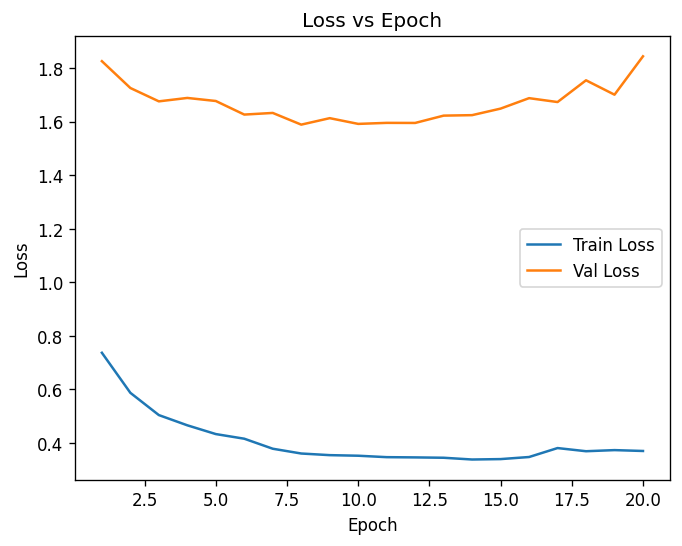

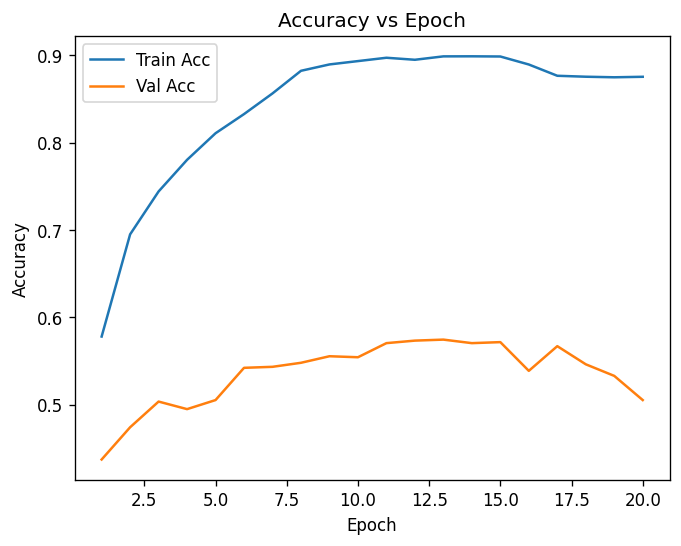

In [24]:
# Cell 2: Training curves (loss & accuracy)
# Provide either `history` (list of tuples: epoch, tr_loss, tr_f1, tr_acc, va_loss, va_f1, va_acc)
# or `metrics_df` with columns train_loss,val_loss,train_acc,val_acc
if 'history' not in globals():
    # Example: load from CSV if you logged metrics each epoch
    # metrics_df = pd.read_csv("metrics.csv")
    # history = {k: metrics_df[k].tolist() for k in ["train_loss","val_loss","train_acc","val_acc"]}
    raise NameError("Please provide a `history` list or load from CSV as shown in the comments.")

epochs = [h[0] for h in history]
train_loss = [h[1] for h in history]
train_acc = [h[3] for h in history]
val_loss = [h[4] for h in history]
val_acc = [h[6] for h in history]

fig, ax = plt.subplots()
ax.plot(epochs, train_loss, label="Train Loss")
ax.plot(epochs, val_loss,   label="Val Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epoch")
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(epochs, train_acc, label="Train Acc")
ax.plot(epochs, val_acc,   label="Val Acc")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs Epoch")
ax.legend()
plt.show()

In [25]:
# Cell 4: Classification report as DataFrame
report_dict = classification_report(y_true, y_pred, labels=range(num_classes), target_names=labels, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
display(report_df.round(3))

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 8, does not match size of target_names, 6
  warnings.warn(


precision  recall  f1-score   support
tensor(0)         0.413   0.528     0.463   381.000
tensor(3)         0.515   0.493     0.504   140.000
tensor(5)         0.459   0.459     0.459    61.000
tensor(3)         0.467   0.449     0.458   314.000
tensor(5)         0.000   0.000     0.000     3.000
tensor(3)         0.797   0.391     0.525   614.000
accuracy          0.489   0.489     0.489     0.489
macro avg         0.421   0.451     0.415  1734.000
weighted avg      0.563   0.489     0.491  1734.000

Unique classes in test set: [0 1 2 3 4 5 6 7]
Skipping class 6 as it is not in labels list.
Skipping class 7 as it is not in labels list.


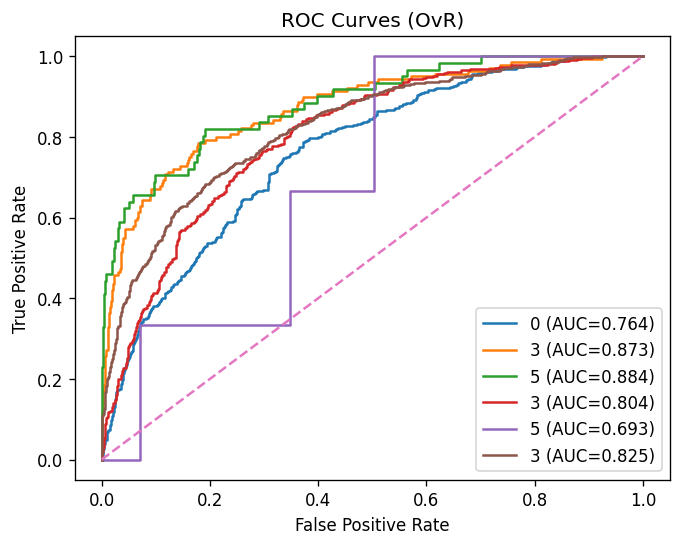

Macro AUC: 0.8071


In [27]:
# Cell 5: ROC curves per class + macro/micro AUC
y_true_bin = label_binarize(y_true, classes=range(num_classes))  # shape [N, C]

auc_scores = []
fig, ax = plt.subplots()

# Get unique classes present in y_true
unique_classes_in_test = np.unique(y_true)
print("Unique classes in test set:", unique_classes_in_test)

for c in unique_classes_in_test:
    # Ensure that the class index 'c' is within the bounds of the 'labels' list
    if c < len(labels):
        fpr, tpr, _ = roc_curve(y_true_bin[:, c], y_score[:, c])
        auc_c = roc_auc_score(y_true_bin[:, c], y_score[:, c])
        auc_scores.append(auc_c)
        ax.plot(fpr, tpr, label=f"{labels[c]} (AUC={auc_c:.3f})")
    else:
        print(f"Skipping class {c} as it is not in labels list.")


ax.plot([0,1], [0,1], linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves (OvR)")
ax.legend()
plt.show()

print("Macro AUC:", np.mean(auc_scores).round(4))

Skipping class 6 as it is not in labels list.
Skipping class 7 as it is not in labels list.


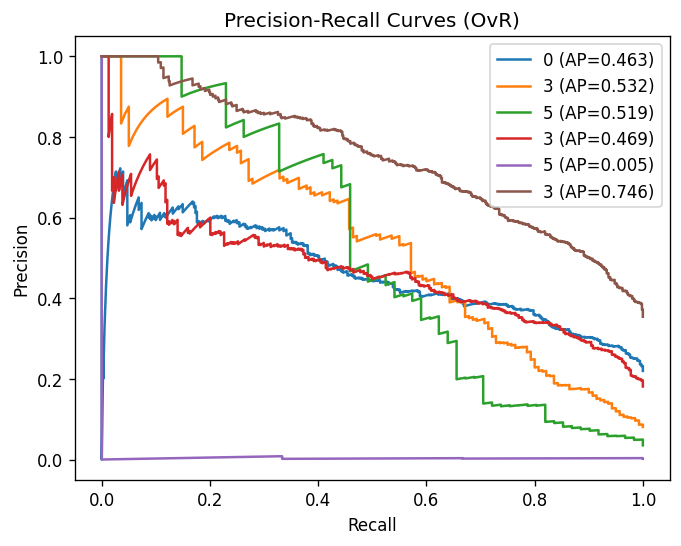

Mean Average Precision (mAP): 0.4556


In [29]:
# Cell 6: PR curves per class + mean Average Precision
aps = []
fig, ax = plt.subplots()

# Get unique classes present in y_true
unique_classes_in_test = np.unique(y_true)

for c in unique_classes_in_test:
    # Ensure that the class index 'c' is within the bounds of the 'labels' list
    if c < len(labels):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, c], y_score[:, c])
        ap = average_precision_score(y_true_bin[:, c], y_score[:, c])
        aps.append(ap)
        ax.plot(recall, precision, label=f"{labels[c]} (AP={ap:.3f})")
    else:
        print(f"Skipping class {c} as it is not in labels list.")


ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curves (OvR)")
ax.legend()
plt.show()

print("Mean Average Precision (mAP):", np.mean(aps).round(4))

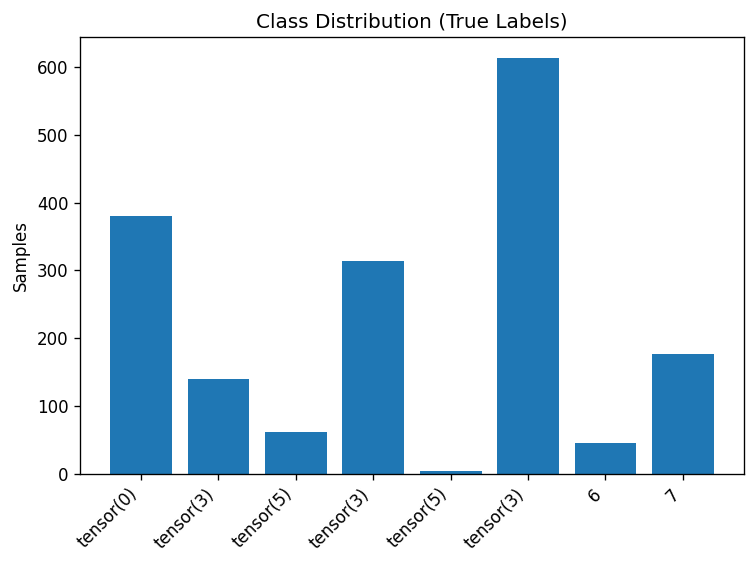

In [42]:
# assumes: y_true (np.array of ints), labels (list of class names OR missing)

counts = pd.Series(y_true).value_counts().sort_index()

# If you have a labels list for all classes, map only the indices that appear.
# Otherwise fall back to index numbers.
if 'labels' in globals() and len(labels) > 0:
    tick_labels = [labels[i] if i < len(labels) else str(i) for i in counts.index]
else:
    tick_labels = [str(i) for i in counts.index]

fig, ax = plt.subplots()
ax.bar(range(len(counts)), counts.values)
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(tick_labels, rotation=45, ha="right")
ax.set_ylabel("Samples")
ax.set_title("Class Distribution (True Labels)")
plt.tight_layout()
plt.show()

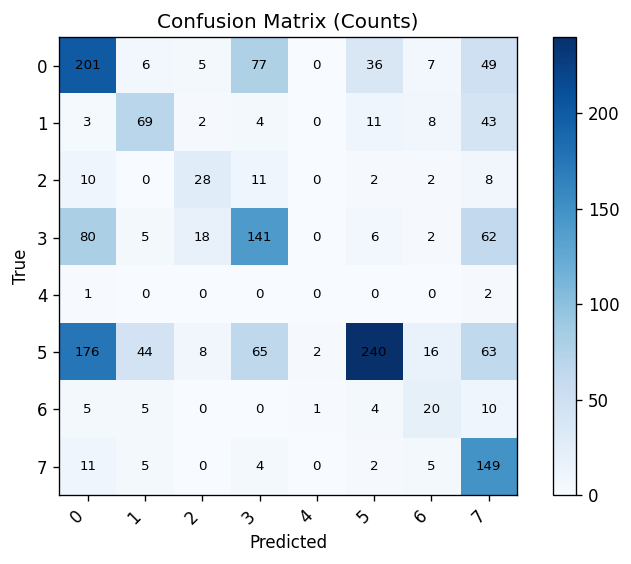

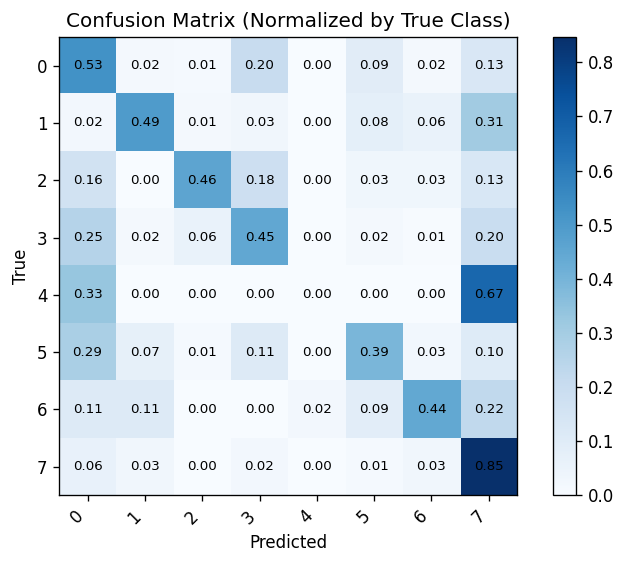

CM shape: (8, 8)  | #labels: 8


In [47]:
# === Confusion Matrix: safe construction + plotting (counts + normalized) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools, json, os

# ---- 1) Decide the canonical label order ----
# Priority: user-provided class_names -> label_map.json -> infer from data
label_order = None

if 'class_names' in globals() and isinstance(class_names, (list, tuple)) and len(class_names) > 0:
    label_order = list(class_names)
elif os.path.exists('/mnt/data/label_map.json'):
    with open('/mnt/data/label_map.json', 'r') as f:
        lm = json.load(f)
    # Accept either {"class_name": idx, ...} or {"idx": "class_name", ...}
    if all(isinstance(v, int) for v in lm.values()):  # name->idx
        # sort by idx
        label_order = [k for k, _ in sorted(lm.items(), key=lambda kv: kv[1])]
    else:  # idx->name
        # map keys to int, sort, then take names
        items = sorted(((int(k), v) for k, v in lm.items()), key=lambda kv: kv[0])
        label_order = [v for _, v in items]

# If still None, infer from y_score (preferred) or y_true
if label_order is None:
    if 'y_score' in globals():
        num_classes = y_score.shape[1]
        label_order = [str(i) for i in range(num_classes)]
    else:
        num_classes = int(np.max(y_true)) + 1
        label_order = [str(i) for i in range(num_classes)]

# Map label names to integer indices 0..C-1 (sklearn's `labels` expects ints)
num_classes = len(label_order)
labels_for_sk = list(range(num_classes))

# ---- 2) Ensure y_true/y_pred are integer indices in [0..C-1] ----
# If your y_true/y_pred are already indices, this is fine. If they are strings, map them.
if isinstance(y_true[0], (np.str_, str)):
    name_to_idx = {n:i for i,n in enumerate(label_order)}
    y_true_idx = np.array([name_to_idx.get(n, -1) for n in y_true], dtype=int)
    y_pred_idx = np.array([name_to_idx.get(n, -1) for n in y_pred], dtype=int)
else:
    y_true_idx, y_pred_idx = y_true, y_pred

# Filter out any -1 (unknown) just in case
mask = (y_true_idx >= 0) & (y_true_idx < num_classes) & (y_pred_idx >= 0) & (y_pred_idx < num_classes)
if not np.all(mask):
    print(f"[warn] Dropping {np.sum(~mask)} samples with out-of-range labels.")
y_true_idx = y_true_idx[mask]
y_pred_idx = y_pred_idx[mask]

# ---- 3) Build square CM with explicit label set to guarantee shape == CxC ----
cm = confusion_matrix(y_true_idx, y_pred_idx, labels=labels_for_sk)
cm_norm = cm.astype(float) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

# ---- 4) Plot helper that auto-aligns tick counts with label_order ----
def plot_cm(M, title, normalize=False):
    fig, ax = plt.subplots()
    im = ax.imshow(M, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(
        xticks=np.arange(M.shape[1]),
        yticks=np.arange(M.shape[0]),
        xticklabels=label_order[:M.shape[1]],
        yticklabels=label_order[:M.shape[0]],
        xlabel="Predicted",
        ylabel="True",
        title=title
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # annotate cells
    for i, j in itertools.product(range(M.shape[0]), range(M.shape[1])):
        text = f"{M[i, j]:.2f}" if normalize else f"{int(M[i, j])}"
        ax.text(j, i, text, ha="center", va="center", fontsize=8)

    fig.tight_layout()
    plt.show()

plot_cm(cm, "Confusion Matrix (Counts)", normalize=False)
plot_cm(cm_norm, "Confusion Matrix (Normalized by True Class)", normalize=True)

print("CM shape:", cm.shape, " | #labels:", len(label_order))

In [34]:
# Cell 8: Top-k accuracy
for k in [1, 3, 5]:
    k = min(k, num_classes)
    acc_k = top_k_accuracy_score(y_true, y_score, k=k, labels=range(num_classes))
    print(f"Top-{k} Accuracy: {acc_k:.4f}")

Top-1 Accuracy: 0.4890
Top-3 Accuracy: 0.8212
Top-5 Accuracy: 0.9429


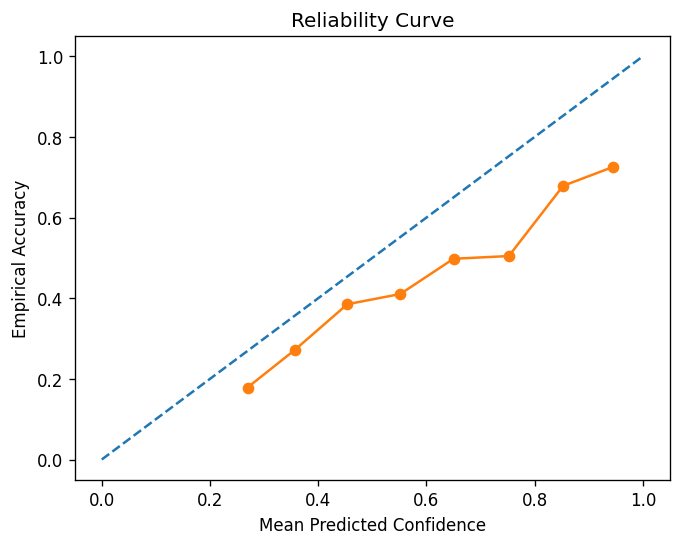

Brier score (macro avg): 0.0852


In [35]:
# Cell 9: Reliability curve (ECE-like visualization) + Brier score (macro)
# We'll compute mean confidence vs. empirical accuracy in bins.
bins = np.linspace(0, 1, 11)
confidences = y_score.max(axis=1)
preds = y_score.argmax(axis=1)
accs = (preds == y_true).astype(float)

bin_ids = np.digitize(confidences, bins) - 1
bin_centers, bin_conf, bin_acc = [], [], []
for b in range(len(bins)-1):
    mask = bin_ids == b
    if mask.any():
        bin_centers.append((bins[b] + bins[b+1]) / 2)
        bin_conf.append(confidences[mask].mean())
        bin_acc.append(accs[mask].mean())

fig, ax = plt.subplots()
ax.plot([0,1],[0,1], linestyle="--")
ax.plot(bin_conf, bin_acc, marker="o")
ax.set_xlabel("Mean Predicted Confidence")
ax.set_ylabel("Empirical Accuracy")
ax.set_title("Reliability Curve")
plt.show()

# Brier score (macro one-vs-rest)
briers = []
for c in range(num_classes):
    y_c = (y_true == c).astype(int)
    p_c = y_score[:, c]
    briers.append(brier_score_loss(y_c, p_c))
print("Brier score (macro avg):", np.mean(briers).round(4))

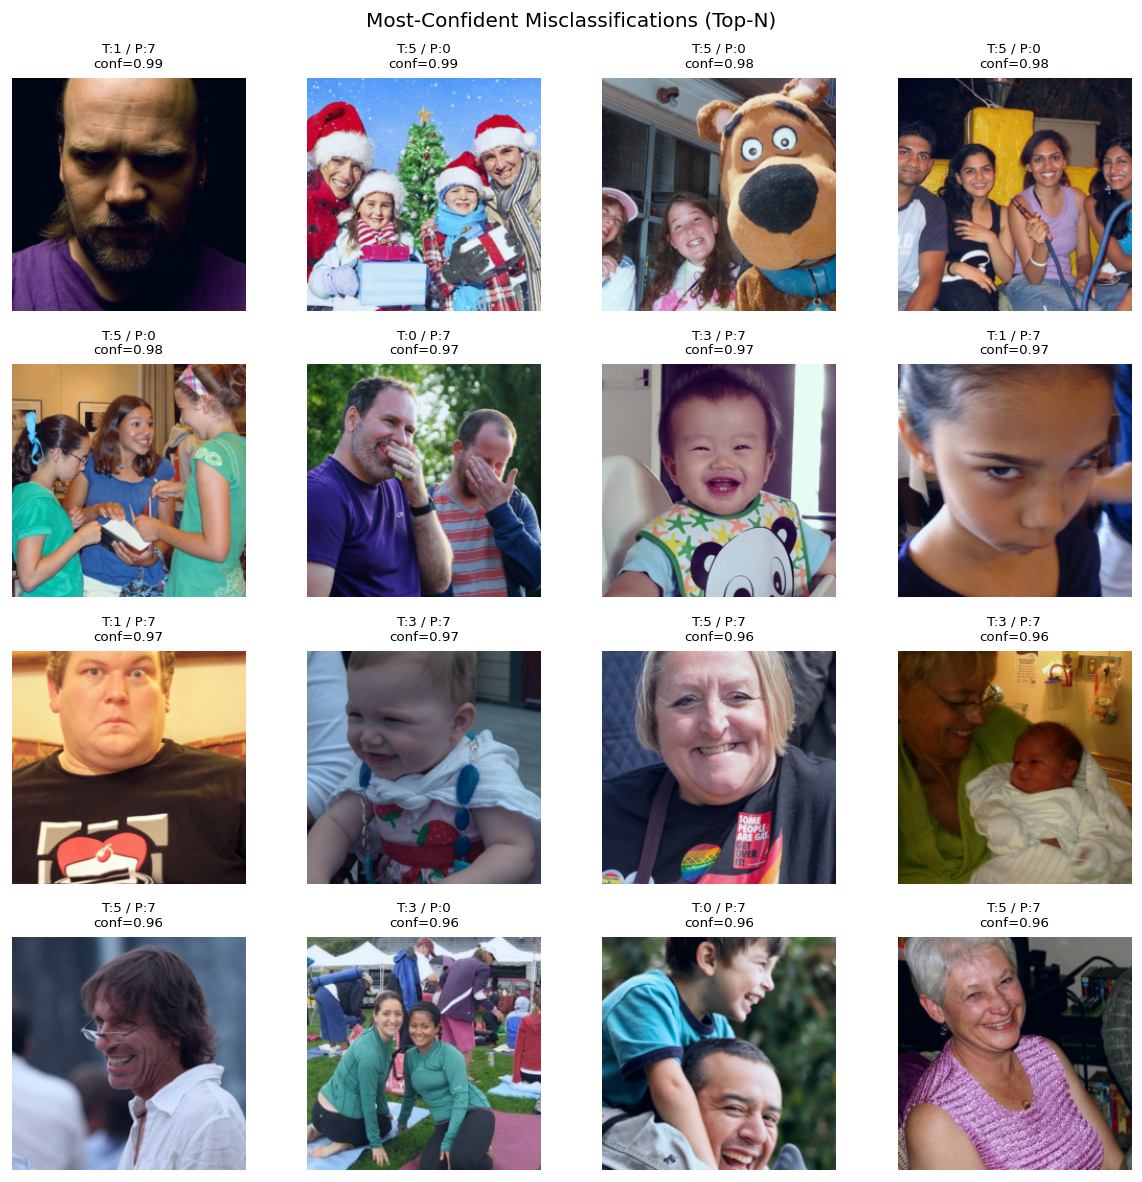

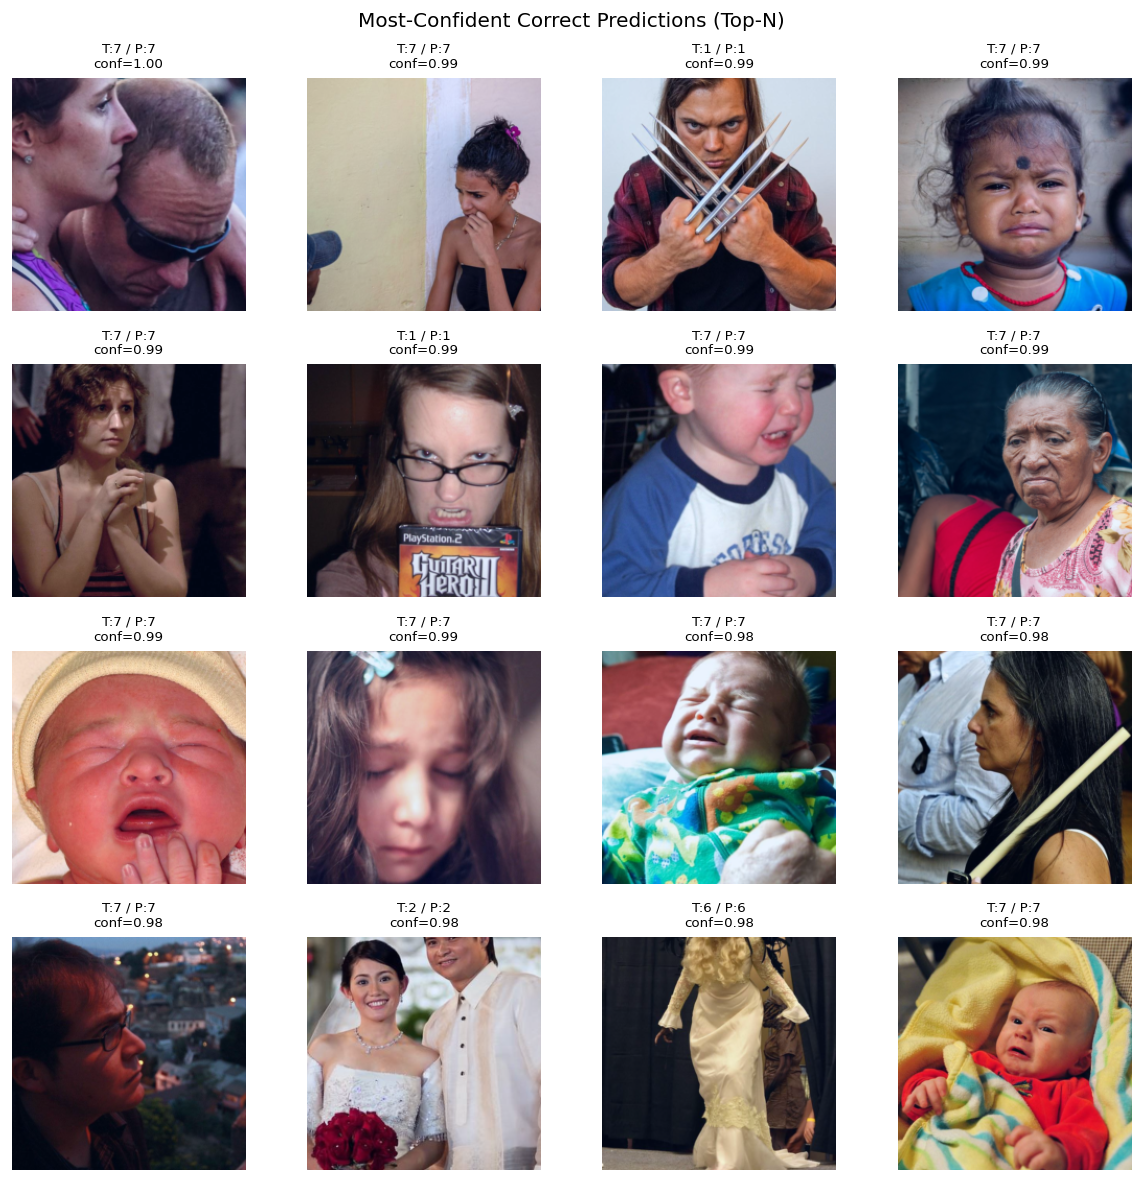

Shown: wrong=16  correct=16  (topN=16)
num_classes: 8  len(labels): 8  unique y_true: [0 1 2 3 4 5 6 7]  unique y_pred: [0 1 2 3 4 5 6 7]


In [51]:
# === Cell: Grids for Most-Confident WRONG and CORRECT predictions ===
import math, numpy as np, torch, matplotlib.pyplot as plt

# --- 0) Choose which loader's dataset to visualize ---
dataset = test_loader.dataset  # change to loader_eval.dataset or val_loader.dataset if needed

# --- 1) Infer num_classes & repair labels list ---
def infer_num_classes():
    if 'y_score' in globals():
        return y_score.shape[1]
    if 'logits' in globals():
        return logits.shape[1]
    return int(max(np.max(y_true), np.max(y_pred))) + 1

num_classes = infer_num_classes()

if 'labels' not in globals() or not isinstance(labels, (list, tuple)):
    labels = [str(i) for i in range(num_classes)]
else:
    if len(labels) < num_classes:
        labels = list(labels) + [f"class_{i}" for i in range(len(labels), num_classes)]
    elif len(labels) > num_classes:
        labels = list(labels)[:num_classes]

def safe_label(i: int) -> str:
    i = int(i)
    return labels[i] if 0 <= i < len(labels) else f"class_{i}"

# --- 2) Confidence from y_score / logits (fallback 1.0) ---
if 'y_score' in globals():
    conf = y_score.max(axis=1)
elif 'logits' in globals():
    z = logits - logits.max(axis=1, keepdims=True)
    probs = np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
    conf = probs.max(axis=1)
else:
    conf = np.ones_like(y_pred, dtype=float)

# --- 3) Build correct/wrong index sets ---
correct_mask = (y_pred == y_true)
idx_correct  = np.where(correct_mask)[0]
idx_wrong    = np.where(~correct_mask)[0]

# Sort by confidence (descending)
topN = 16  # change as you wish
order_c = np.argsort(-conf[idx_correct]) if idx_correct.size else np.array([], dtype=int)
order_w = np.argsort(-conf[idx_wrong])   if idx_wrong.size else np.array([], dtype=int)

top_correct = idx_correct[order_c[:topN]]
top_wrong   = idx_wrong[order_w[:topN]]

# --- 4) Helper to convert a dataset sample to a plottable image ---
def to_disp(img_t):
    # Supports: tensor CHW (1 or 3 channels) or PIL/ndarray
    if torch.is_tensor(img_t):
        if img_t.ndim == 3 and img_t.shape[0] in (1,3):
            if img_t.shape[0] == 1:
                arr = img_t.squeeze(0).cpu().numpy()
                return arr, 'gray'
            else:
                arr = img_t.permute(1,2,0).cpu().numpy()
                # normalize to 0..1 for display
                arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-6)
                return arr, None
        else:
            arr = img_t.cpu().numpy()
            return arr, 'gray'
    else:
        # PIL.Image or ndarray
        arr = np.array(img_t)
        return arr, None

# --- 5) Generic grid plotter ---
def plot_grid(indices, title="Samples", ncols=4):
    if len(indices) == 0:
        print(f"No samples to show for: {title}")
        return
    nrows = math.ceil(len(indices) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    axes = np.atleast_1d(axes).flatten()

    for ax, idx in zip(axes, indices):
        sample = dataset[idx]
        # Support (img, label) or (img, label, *extras)
        img_t, true_lab = sample[0], int(sample[1])

        disp, cmap = to_disp(img_t)
        ax.imshow(disp, cmap=cmap)
        ax.axis("off")

        pred_lab = int(y_pred[idx])
        conf_i   = float(conf[idx])
        ax.set_title(f"T:{safe_label(true_lab)} / P:{safe_label(pred_lab)}\nconf={conf_i:.2f}", fontsize=8)

    # turn off unused axes
    for k in range(len(indices), len(axes)):
        axes[k].axis("off")

    fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()

# --- 6) Plot both: WRONG and CORRECT ---
plot_grid(top_wrong,   title="Most-Confident Misclassifications (Top-N)")
plot_grid(top_correct, title="Most-Confident Correct Predictions (Top-N)")

print(f"Shown: wrong={len(top_wrong)}  correct={len(top_correct)}  (topN={topN})")
print("num_classes:", num_classes, " len(labels):", len(labels),
      " unique y_true:", np.unique(y_true),
      " unique y_pred:", np.unique(y_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 8, does not match size of target_names, 6
  warnings.warn(


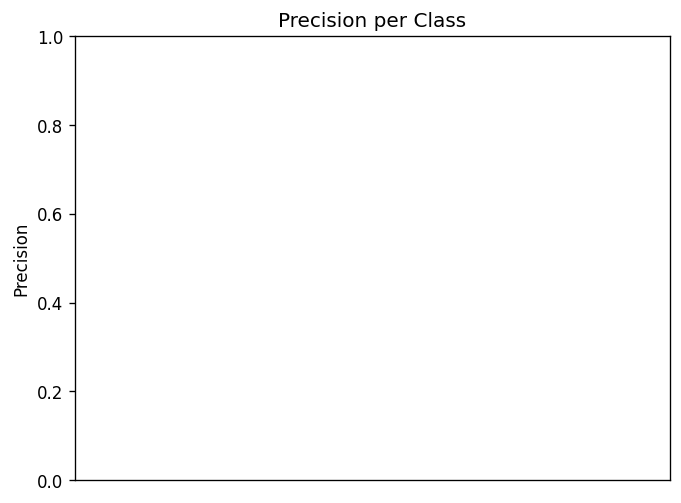

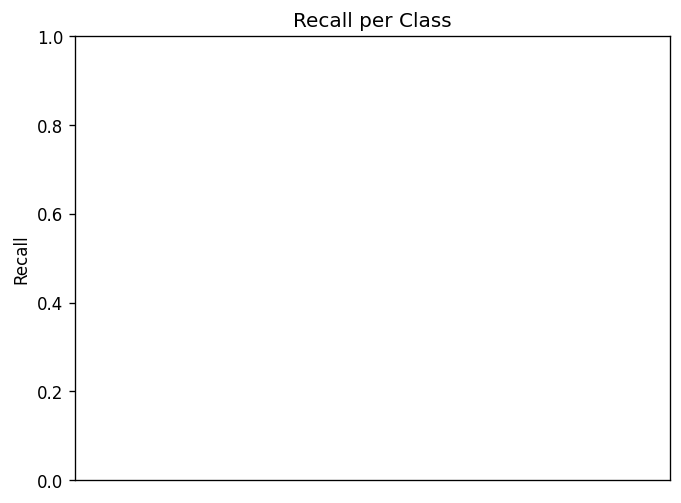

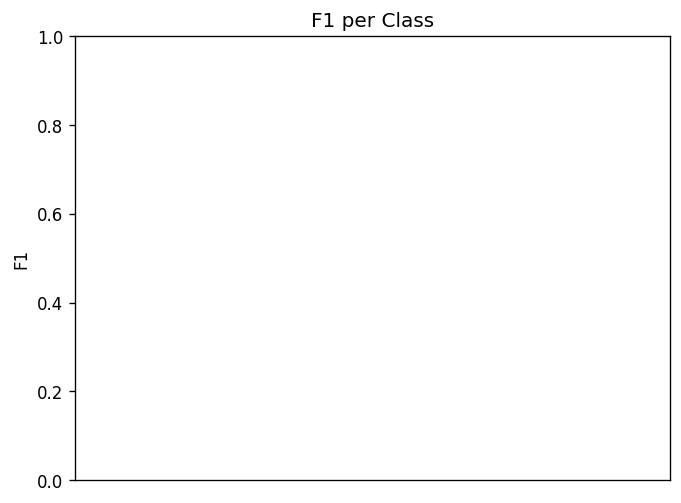

Empty DataFrame
Columns: [class, precision, recall, f1]
Index: []

In [38]:
# Cell 11: Bar charts for F1 / Precision / Recall per class
rep = classification_report(y_true, y_pred, labels=range(num_classes), target_names=labels, output_dict=True)
rows = []
for c in labels:
    if c in rep:
        rows.append([c, rep[c]['precision'], rep[c]['recall'], rep[c]['f1-score']])
per_class_df = pd.DataFrame(rows, columns=["class","precision","recall","f1"])

for metric in ["precision","recall","f1"]:
    fig, ax = plt.subplots()
    ax.bar(range(len(per_class_df)), per_class_df[metric].values)
    ax.set_xticks(range(len(per_class_df))); ax.set_xticklabels(per_class_df["class"], rotation=45, ha="right")
    ax.set_ylim(0,1)
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f"{metric.capitalize()} per Class")
    plt.show()

display(per_class_df.round(3))

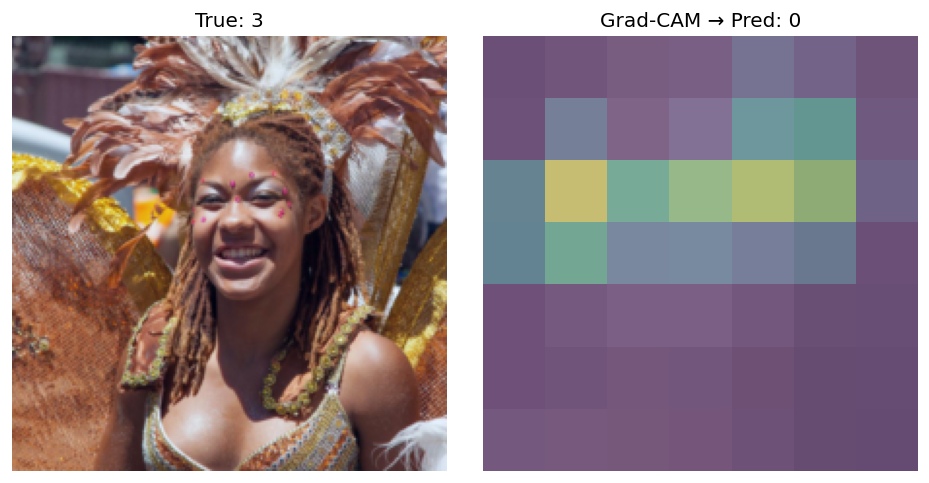

In [41]:
# Cell 12: Minimal Grad-CAM for one sample index
# Pick an index from your eval dataset:
sample_idx = 0  # change as needed

# ---- Adapt these two lines for your model ----
target_layer = None
# Example: if your model has model.features as nn.Sequential and last conv at -1:
for m in reversed(list(model.modules())):
    if isinstance(m, torch.nn.Conv2d):
        target_layer = m
        break
assert target_layer is not None, "Couldn't find a Conv2d layer; set `target_layer` manually."

# Grab image and forward once
model.eval()
img, true_lab = test_loader.dataset[sample_idx]
x = img.unsqueeze(0).to(device)

activations = []
grads = []

def fwd_hook(module, inp, out):
    activations.append(out.detach())

def bwd_hook(module, grad_in, grad_out):
    grads.append(grad_out[0].detach())

h1 = target_layer.register_forward_hook(fwd_hook)
h2 = target_layer.register_full_backward_hook(bwd_hook)

logits = model(x)
cls = logits.argmax(dim=1).item()
score = logits[0, cls]
model.zero_grad()
score.backward()

A = activations[-1][0]        # [C, H, W]
G = grads[-1][0]               # [C, H, W]
weights = G.mean(dim=(1,2))    # [C]
cam = torch.sum(weights[:, None, None] * A, dim=0).cpu().numpy()
cam = np.maximum(cam, 0)
cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)

h1.remove(); h2.remove()

# Prepare display image (assuming CHW, 0..1)
vis = img.permute(1,2,0).numpy()
vis = (vis - vis.min()) / (vis.max() - vis.min() + 1e-6)

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow(vis); ax[0].axis("off"); ax[0].set_title(f"True: {labels[true_lab]}")
ax[1].imshow(vis, alpha=0.6)
ax[1].imshow(cam, alpha=0.4)
ax[1].axis("off")
ax[1].set_title(f"Grad-CAM → Pred: {labels[cls]}")
plt.tight_layout(); plt.show()